In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

In [3]:

df = pd.read_csv('../data/heart_disease_cleaned.csv')
X = df.drop('target', axis=1)
y_true = df['target']  


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Data shape: {X_scaled.shape}")

Data shape: (1190, 11)


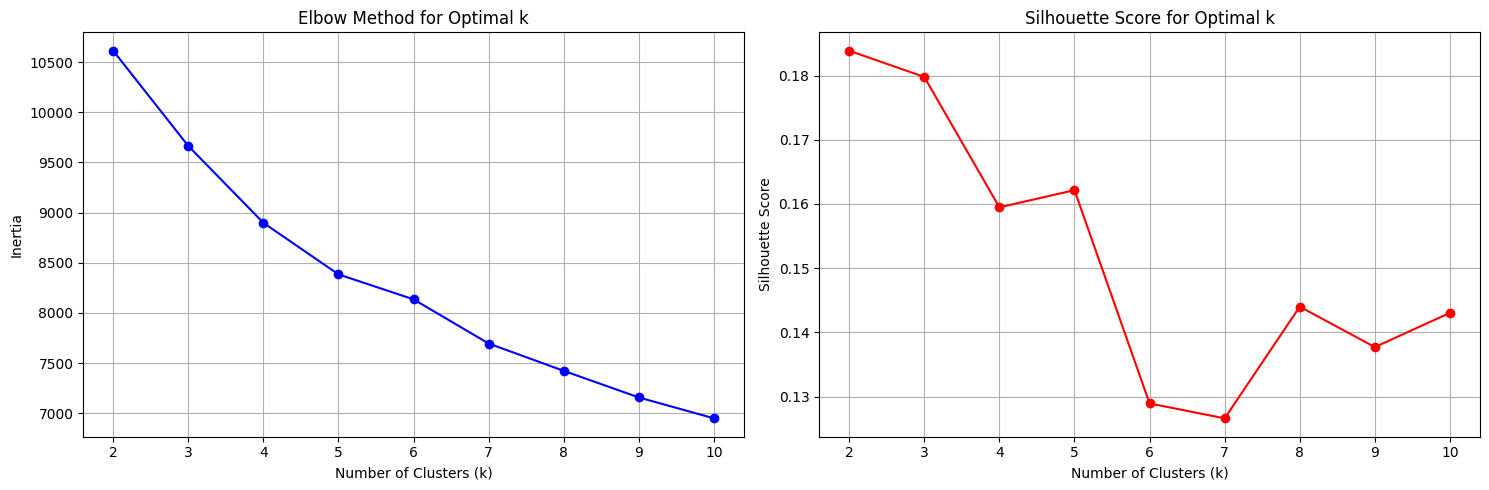

Optimal number of clusters (based on silhouette score): 2


In [4]:
# Calculate inertia for different k values
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Method
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Inertia plot
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

# Silhouette score plot
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Optimal k')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (based on silhouette score): {optimal_k}")

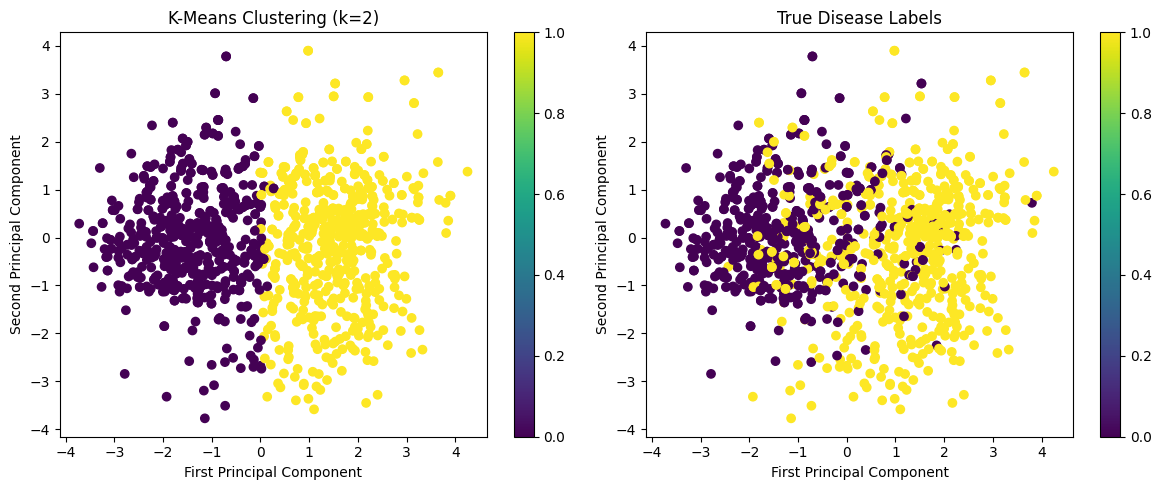

In [5]:
# Apply K-Means with optimal k
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_optimal.fit_predict(X_scaled)

# Visualize K-Means results (using PCA for 2D visualization)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

# K-Means clusters
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)

# True labels for comparison
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='viridis')
plt.title('True Disease Labels')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

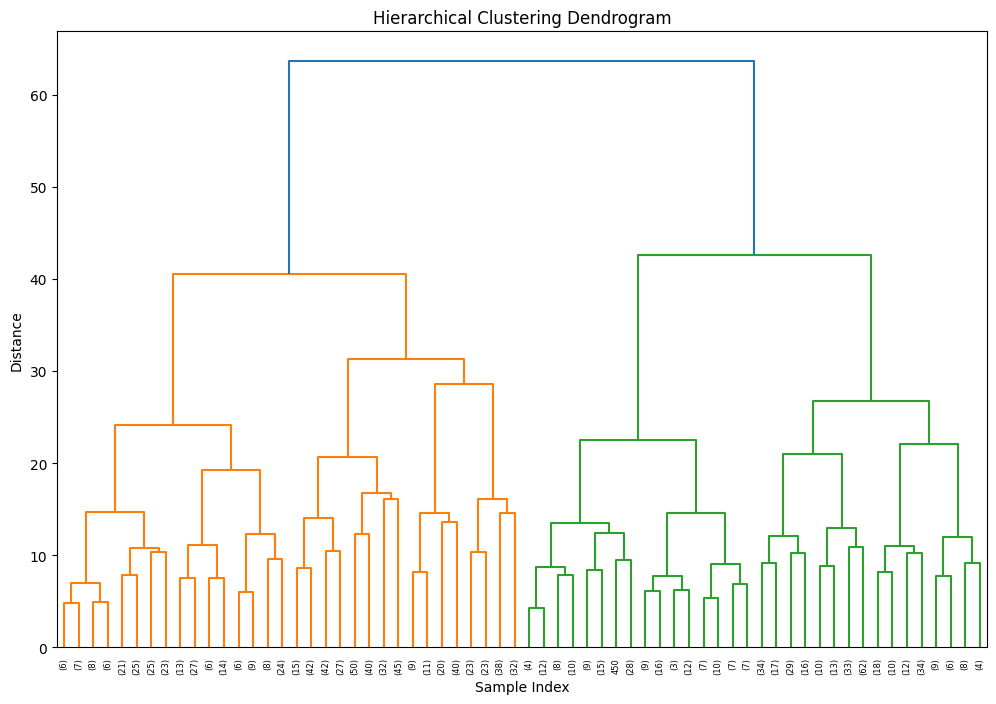

In [6]:
# Create linkage matrix
linkage_matrix = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

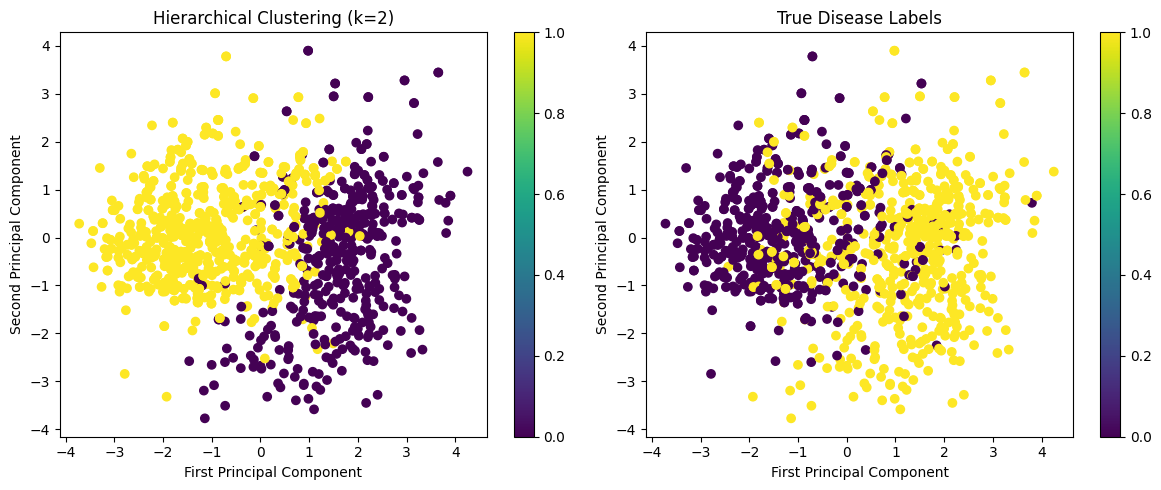

In [7]:
# Apply hierarchical clustering with optimal k
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Visualize hierarchical clustering results
plt.figure(figsize=(12, 5))

# Hierarchical clusters
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='viridis')
plt.title(f'Hierarchical Clustering (k={optimal_k})')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)

# True labels for comparison
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='viridis')
plt.title('True Disease Labels')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

In [8]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'True_Label': y_true,
    'KMeans_Cluster': kmeans_labels,
    'Hierarchical_Cluster': hierarchical_labels
})

print("Cluster Distribution:")
print("\nK-Means Clusters:")
print(comparison_df['KMeans_Cluster'].value_counts().sort_index())

print("\nHierarchical Clusters:")
print(comparison_df['Hierarchical_Cluster'].value_counts().sort_index())

print("\nTrue Labels:")
print(comparison_df['True_Label'].value_counts().sort_index())

Cluster Distribution:

K-Means Clusters:
KMeans_Cluster
0    613
1    577
Name: count, dtype: int64

Hierarchical Clusters:
Hierarchical_Cluster
0    473
1    717
Name: count, dtype: int64

True Labels:
True_Label
0.0    561
1.0    629
Name: count, dtype: int64



K-Means Clusters vs True Labels:
True_Label      0.0  1.0
KMeans_Cluster          
0               475  138
1                86  491

Hierarchical Clusters vs True Labels:
True_Label            0.0  1.0
Hierarchical_Cluster          
0                      56  417
1                     505  212


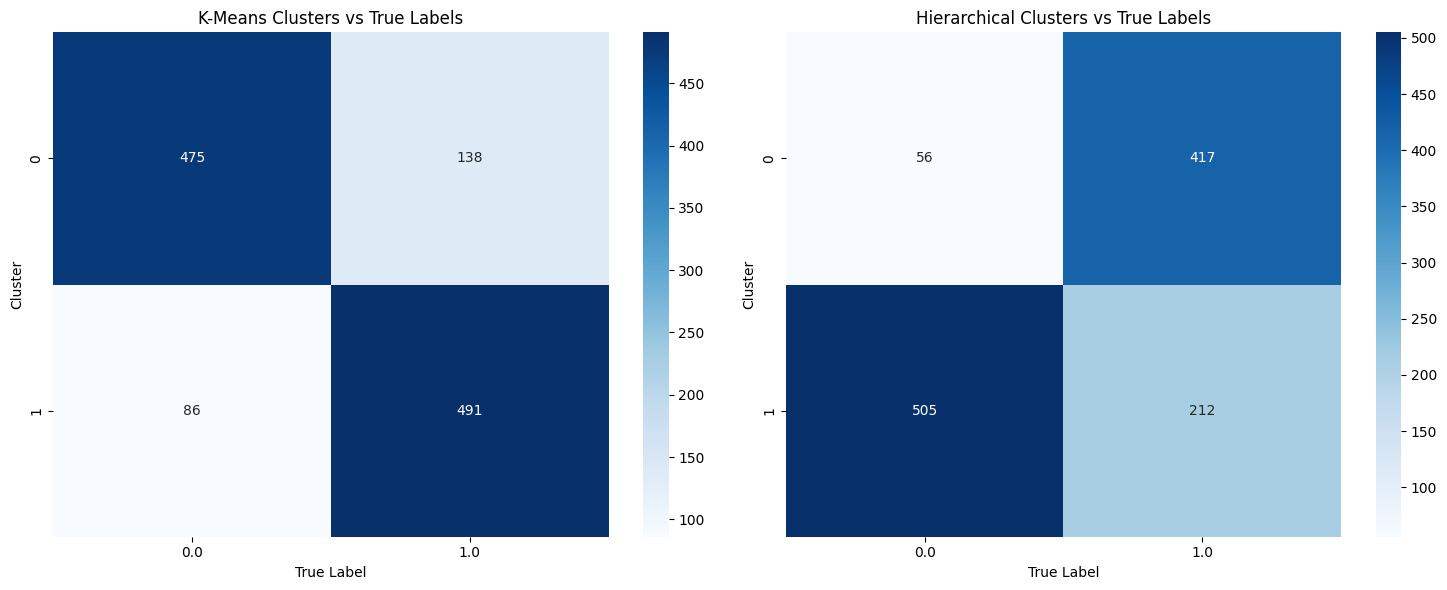

In [9]:
# Cross-tabulation analysis
print("\nK-Means Clusters vs True Labels:")
kmeans_crosstab = pd.crosstab(comparison_df['KMeans_Cluster'], comparison_df['True_Label'])
print(kmeans_crosstab)

print("\nHierarchical Clusters vs True Labels:")
hierarchical_crosstab = pd.crosstab(comparison_df['Hierarchical_Cluster'], comparison_df['True_Label'])
print(hierarchical_crosstab)

# Visualize the relationships
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# K-Means heatmap
sns.heatmap(kmeans_crosstab, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('K-Means Clusters vs True Labels')
ax1.set_xlabel('True Label')
ax1.set_ylabel('Cluster')

# Hierarchical heatmap
sns.heatmap(hierarchical_crosstab, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Hierarchical Clusters vs True Labels')
ax2.set_xlabel('True Label')
ax2.set_ylabel('Cluster')

plt.tight_layout()
plt.show()

In [10]:
# Add cluster labels to original data for analysis
df_with_clusters = df.copy()
df_with_clusters['KMeans_Cluster'] = kmeans_labels
df_with_clusters['Hierarchical_Cluster'] = hierarchical_labels

# Analyze cluster characteristics
print("\nK-Means Cluster Characteristics:")
for cluster in range(optimal_k):
    cluster_data = df_with_clusters[df_with_clusters['KMeans_Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Size: {len(cluster_data)}")
    print(f"Disease Rate: {cluster_data['target'].mean():.3f}")
    print(f"Average Age: {cluster_data['age'].mean():.1f}")

print("\nHierarchical Cluster Characteristics:")
for cluster in range(optimal_k):
    cluster_data = df_with_clusters[df_with_clusters['Hierarchical_Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Size: {len(cluster_data)}")
    print(f"Disease Rate: {cluster_data['target'].mean():.3f}")
    print(f"Average Age: {cluster_data['age'].mean():.1f}")


K-Means Cluster Characteristics:

Cluster 0:
Size: 613
Disease Rate: 0.225
Average Age: -0.4

Cluster 1:
Size: 577
Disease Rate: 0.851
Average Age: 0.4

Hierarchical Cluster Characteristics:

Cluster 0:
Size: 473
Disease Rate: 0.882
Average Age: 0.4

Cluster 1:
Size: 717
Disease Rate: 0.296
Average Age: -0.3


In [11]:
# Save clustering results
comparison_df.to_csv('../results/clustering_results.csv', index=False)
print("Clustering results saved to '../results/clustering_results.csv'")

# Save models
import joblib
joblib.dump(kmeans_optimal, '../models/kmeans_model.pkl')
joblib.dump(hierarchical, '../models/hierarchical_model.pkl')
print("Clustering models saved to '../models/'")

Clustering results saved to '../results/clustering_results.csv'
Clustering models saved to '../models/'
